In [ ]:
!pip3 install numpy pandas matplotlib

In [1]:
# Create a new conda environment with the following command:
# conda create -n bench python=3 pandas seaborn matplotlib numpy
# conda activate bench

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib import rcParamsDefault
from matplotlib.colors import ListedColormap
import pandas as pd

In [2]:
figure_save = False
figure_fmt = 'pdf'
path_suffix = '-best_mr_copy'
yir_mans_nice_fonts = {
    "xtick.labelsize": 8,
}
rcParams.update(rcParamsDefault)
rcParams.update(yir_mans_nice_fonts)
rcParams.update({'figure.autolayout': True})
cmap = plt.get_cmap('cividis')
lower_limit = 0
upper_limit = 0.85
new_cmap = cmap(np.linspace(lower_limit, upper_limit, cmap.N))
#reverse the color order
new_cmap = new_cmap[::-1]
new_cmap = ListedColormap(new_cmap)

In [3]:
def update_legend_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    for i, label in enumerate(labels):
        label = label.replace('value, ', '')
        label = label.replace(')', '')
        label = label.replace('(', '')

        # Some mapping
        label = label.replace('mlir_ACC', 'mlir_AXI4MLIR')
        label = label.replace('mlir_CPU', 'mlir_CPU')
        label = label.replace('cpp_MAN',  'cpp_MANUAL')
        labels[i] = label

    # edit labels in legend
    ax.legend(handles, labels)
    return handles, labels


# Experiment 1

In [4]:
figure_save = True
figure_fmt = 'pdf'
path_suffix = '-best_mr_copy'
rcParams.update({'figure.autolayout': True})
file_path = '../ex1_pynq/results/results-latest.csv'

# read file into rows
rows = []
with open(file_path, 'r') as f:
    for line in f:
        rows.append(line.split(','))


df = pd.DataFrame.from_records(rows)
df.head()
df = df.iloc[:, 0:12]
df = df.drop(columns=[10])
df.head()
df.columns = ['problem_size', 'dims', 'kernel', 'tool', 'accel_size',
              'accel_version', 'strategy', 'threads', 'board', 'value', 'metric']
df.head()
df['accel_size'] = df['accel_size'].astype(int)
df['dims'] = df['problem_size'].str.split('_').str[0]
df['dims'] = df['dims'].astype(int)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df = df.drop(columns=['problem_size'])
df = df.drop(columns=['threads'])
all_columns = df.columns

def filter_df(df, filter_dict):
    """Filter the df based on dictionary key pairs"""
    filter = []
    for key, value in filter_dict.items():
        filter.append(df[key] == value)
    filter = np.array(filter).all(axis=0)
    return df[filter]

## Normalized data

In [5]:
# Prepare for normalization
all_columns = df.columns
columns_to_pivot = ['metric']
values_to_pivot = ['value']
# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in columns_to_pivot + values_to_pivot]
df_p = df.pivot(index=pv_index, columns=columns_to_pivot,
                values=values_to_pivot[0])
df_p = df_p.reset_index()

# Normalize all values based on row mlir_CPU, accel_size=0, accel_version=NONE, strategy=NONE, dims=<dims_value>
# columns to normalize: c
c = df['metric'].unique()

for d in df_p['dims'].unique():
    cpu_loc = (df_p['tool'] == 'mlir_CPU') & (df_p['dims'] == d)
    acc_loc = (df_p['tool'] == 'mlir_ACC') & (df_p['dims'] == d)
    man_loc = (df_p['tool'] == 'cpp_MAN') & (df_p['dims'] == d)

    # assert count of True values in cpu_loc is 1
    assert sum(cpu_loc) == 1

    # Normalize accelerator values by CPU values, then normalize CPU values by CPU values
    df_p.loc[acc_loc, c] = df_p.loc[acc_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[man_loc, c] = df_p.loc[man_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[cpu_loc, c] = df_p.loc[cpu_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)

df_n = df_p
df_n.head()

# Transform df_n that has one metric per column to df_n2 that has one metric per row
df_n2 = df_n.melt(id_vars=pv_index, value_vars=c,
                  var_name='metric', value_name='value')
# df_n2.head()


## Figure 12b

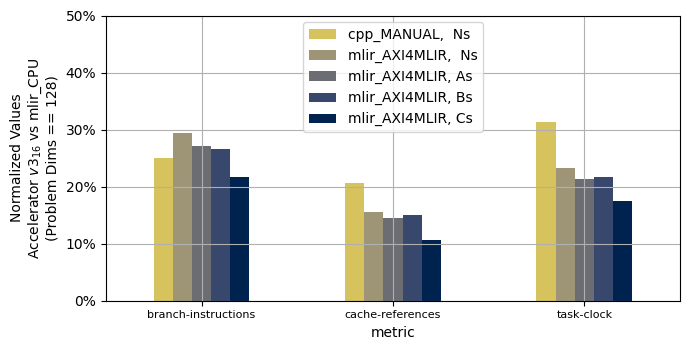

In [6]:
# Edit the following variables to change the plot
experiment = 'plot-manual-vs-mlir-flows-128-16-counters-limited'
logy = False
y_label = 'Normalized Values\nAccelerator $v3_{16}$ vs mlir_CPU\n(Problem Dims == 128)'
x_label_rotation = True
title = ''
figure_size = (7, 3.6)

# What to plot
to_plot = ['value']
pv_columns = ['tool', 'strategy']

# ==============================================================================
figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
filter_dict['accel_version'] = 'v3'
filter_dict['dims'] = 128
filter_dict['accel_size'] = 16

filtered_df = filter_df(df_n2, filter_dict)

filtered_df = filtered_df[filtered_df.metric.isin(
    ['task-clock', 'cache-references', 'branch-instructions'])]
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']
filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# filter out tool cpp_MAN that is not strategy Ns
positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
    filtered_df['strategy'] != 'Ns')
filtered_df = filtered_df[~positive_filter]

# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

ax = df_to_plot.plot(cmap=new_cmap, kind='bar', figsize=figure_size, logy=logy)
ax.grid()

plt.title(title)
plt.ylabel(y_label)
plt.ylim(0.0, 0.5)
# Transform axis to percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# legend to top middle
handles, labels = update_legend_labels(ax)
ax.legend(handles, labels, loc='upper center')

if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


## Figure 13

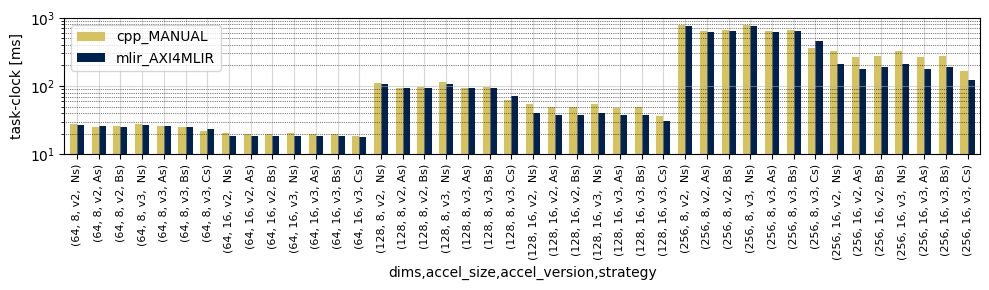

In [7]:
# Edit the following variables to change the plot

experiment = 'plot-manual-vs-mlir-genereated-all-ns-vs-all-logscale'
logy = True
y_label = 'task-clock [ms]'
x_label_rotation = False
title = ''
figure_size = (10, 3)

# What to plot
# to_plot = ['value']
pv_columns = ['strategy', 'tool']
pv_columns = ['tool', 'strategy']
# pv_columns = ['strategy']
pv_columns = ['tool']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)
filter_dict = {}
filter_dict['metric'] = 'task-clock'
filtered_df = filter_df(df, filter_dict)
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']
filtered_df = filtered_df[filtered_df.accel_version != 'v1']
filtered_df = filtered_df[filtered_df.accel_size != 4]
filtered_df = filtered_df[filtered_df.dims >= 64]


# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})

# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped
ax = df_to_plot.plot(cmap=new_cmap, kind='bar', figsize=figure_size, logy=logy, width=0.65)
ax.set_yticks([10, 100, 1000])
update_legend_labels(ax)
ax.grid()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(alpha=0.5)

plt.title(title)
plt.ylabel(y_label)
if (x_label_rotation):
    plt.xticks(rotation=55, ha='right')

if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()